In [1]:
clear
homedir = getenv('HOME');
workdir = getenv('WORK');
scradir = getenv('SCRATCH');
fprintf(1,'\n$HOME=%s\n$WORK=%s\n$SCRATCH=%s\n\n',homedir,workdir,scradir);
addpath(genpath([homedir '/work_MOM']));
addpath(genpath([homedir '/mytoolbox']));
addpath(genpath([homedir '/MyFuncs']));


$HOME=/glade/u/home/yueyanglu
$WORK=/glade/work/yueyanglu
$SCRATCH=/glade/derecho/scratch/yueyanglu



In [2]:

%-------- dir for  
tmStr = '_180d';
grid_dir = [workdir '/MOM6_exp/mom_lowRES/'];  
exp_dir = [workdir '/MOM6_OUT/tr_off_64' tmStr '/'];
h_dir = [workdir '/MOM6_OUT/forc_uvh_64/sol_h' tmStr '/'];   % hL & dhLdt
chi_dir = [workdir  '/MOM6_OUT/tr_off_64' tmStr '/params/lmddotn_SIGNxmean_ka400_usesol_prog_addreld10/C09/'];
% 
tr_dir = [exp_dir 'sols_pt/tr_forcprog_addrel10d_ptrel/'];
tr_dir2 = [exp_dir 'sols_pt/tr_noforc_ptrel_paramka400Chidotn_SIGNEXACT_useC09/'];
eforc_dir = [exp_dir 'cforc_pt_prog_addreld10/'];
eforc_dir2 = [exp_dir 'sols_pt/tr_noforc_ptrel_paramka400Chidotn_SIGNEXACT_useC09/paramforc/'];

% 
tr_name = 'tr1';
eforc_varnm = 'cforc_rel1';

% ------ time
yr_s = 21;
[day_s, day_e, dt] = deal(1, 729, 1); 
dt_flxmean = 6/24;
t_al = day_s:dt:day_e;
nt_al = length(t_al);
fprintf(1,'Will do time = Y%s D%s-D%s.\n',num2str(yr_s), num2str(t_al(1)), num2str(t_al(end)) );

%-------- read model grid
[grid, ~, ~] = read_grid_MOM([grid_dir '']); % SOLUTION/
nk = length(grid.Layer);
onesH = ones(grid.nih,grid.njh);
klay = 1;

Will do time = Y21 D1-D729.


In [3]:
[chin_t,un_t,undir_t] = deal(zeros(grid.nih,grid.njh,nk,nt_al));

for it = 1:nt_al

    [t1, t2] = deal(t_al(it), t_al(it)+dt_flxmean);
    t15 = (t1 + t2)/2;
    [yrstr, dystr, hrstr] = get_timestr(t1, yr_s);
    [yrstr15, dystr15, hrstr15] = get_timestr(t15, yr_s); 
    
    %---- read
    chin_fnm = [chi_dir 'K__' yrstr '_' dystr '_' hrstr '.nc'];
    tr_fnm = [tr_dir 'tr__' yrstr '_' dystr '_' hrstr '.nc'];
    tr_fnm2 = [tr_dir2 'tr__' yrstr '_' dystr '_' hrstr '.nc'];
    h_fnm = [h_dir 'h_snap__' yrstr '_' dystr '_' hrstr '.nc'];
    eforc_fnm = [eforc_dir 'forc__' yrstr '_' dystr '_' hrstr '.nc'];
    eforc_fnm2 = [eforc_dir2 'forc__' yrstr '_' dystr '_' hrstr '.nc'];
    ds_chi = ncstruct(chin_fnm);
    ds_h = ncstruct(h_fnm);
    ds_tr = ncstruct(tr_fnm);
    ds_tr2 = ncstruct(tr_fnm2);
    ds_ef = ncstruct(eforc_fnm);
    ds_ef2 = ncstruct(eforc_fnm2);
    %
    chidotn = ds_chi.chidotn;
    % chidotn = filter_extreme(chidotn,1,99);
    chin_t(:,:,it) = chidotn(:,:,klay);
    
    %--- get 
    h = ds_h.h(:,:,klay);
    c = ds_tr.tr1(:,:,klay);
    c2 = ds_tr2.tr1(:,:,klay);
    eforc = ds_ef.(eforc_varnm)(:,:,klay);
    eforc2 = ds_ef2.cforc1(:,:,klay); 
    % 
    [hcx,hcy] = calc_GxGy_CG(c,h,grid.dxCu,grid.dyCu,grid.dxCv,grid.dyCv,0);
    hcx([1 end],:) = 0; hcy(:,[1 end]) = 0;
    [hcx_p,hcy_p] = uv2p_CG(hcx,hcy);
    [cx,cy] = calc_GxGy_CG(c2,onesH,grid.dxCu,grid.dyCu,grid.dxCv,grid.dyCv,0); 
    cx([1 end],:) = 0; cy(:,[1 end]) = 0;
    [cx_p,cy_p] = uv2p_CG(cx,cy);
    cgrad_norm = sqrt(hcx_p.^2 + hcy_p.^2);
    [nx, ny] = deal(hcx_p ./ cgrad_norm, hcy_p ./ cgrad_norm); 

    c_al(:,:,it) = c;
    c2_al(:,:,it) = c2;
    % 
    cy2_al(:,:,it) = cy_p.^2;
    vol_al(:,:,it) = h.* grid.Ah; %[m3]
    cm_al(:,:,it) = c2 .*h.*grid.Ah;
    %
    eforc_al(:,:,it) = eforc;
    eforc2_al(:,:,it) = eforc2;
end

## get GS core

In [4]:
ds_GS = load('GScore_mom_unsm_wide.mat'); % GScore_mom_unsm_wide or GScore_mom_5yr

[ii_GS, jj_GS] = deal(ds_GS.ii, ds_GS.jj);
[x_GSC_t, y_GSC_t, id_lat_spdt] = deal(zeros(length(ii_GS),nt_al));

for it = 1:nt_al
    it_ds = find(t_al(it) == ds_GS.t_al);
    id_lat_spdt(:,it) = ds_GS.id_lat_spdt(:,it_ds);
    x_GSC_t(:,it) = ds_GS.x_GSC_t(:,it_ds);
    y_GSC_t(:,it) = ds_GS.y_GSC_t(:,it_ds);
end
x_GSC_m = ds_GS.x_GSC_m;
y_GSC_m = ds_GS.y_GSC_m;

## calc spatial mean (dc/dy)^2

In [5]:
[x, y] = deal(grid.lonh, grid.lath);
xlims = [0 3000]; ylims = [1600 2400];
[~, ii_s] = min(abs(x - xlims(1))); [~, ii_e] = min(abs(x - xlims(2)));
[~, jj_s] = min(abs(y - ylims(1))); [~, jj_e] = min(abs(y - ylims(2)));
[ii_rec, jj_rec] = deal(ii_s:ii_e, jj_s:jj_e);

fld_do = cy2_al; % cy_al delc_norm
% idx for GS core
for iGS = 1:length(x_GSC_m)
    [~, ii_GS_est(iGS)] = min(abs(x - x_GSC_m(iGS)));
    [~, jj_GS_est(iGS)] = min(abs(y - y_GSC_m(iGS)));
    for it = 1:nt_al
        [~, ii_GS_est_t(iGS,it)] = min(abs(x - x_GSC_t(iGS,it)));
        [~, jj_GS_est_t(iGS,it)] = min(abs(y - y_GSC_t(iGS,it)));
    end
end
% 
for it = 1:nt_al
    %
    fxy = (fld_do(ii_GS_est(1:end),jj_GS_est(1:end),it));
    mean_GSC(it) = mean(fxy,[1 2],'omitnan') ;
end


## calc the tracer mass averaged between GS core and rectangle boundary

In [6]:

% for each longitude at GS core, get jj's N and S of the jet
[fld_sum_N, fld_sum_S, vol_sum_N, vol_sum_S, c_mean_N, c_mean_S] = deal(cell(1,1)); 
[fld_sum_N(:), fld_sum_S(:), vol_sum_N(:), vol_sum_S(:), c_mean_N(:), c_mean_S(:)] = deal({zeros(1,nt_al)});
[jj_N, jj_S] = deal( cell(1,length(ii_GS),nt_al) ); 

icel = 1;
for it = 1:nt_al
    fxy = squeeze(cm_al(:,:,it));
    cxy = squeeze(c2_al(:,:,it));

    numsum_N = 0;
    numsum_S = 0;
    for i = 1:length(ii_GS)
        jj_N{icel,i,it} = jj_GS(id_lat_spdt(i,it))+1 : jj_rec(end);
        jj_S{icel,i,it}  = jj_rec(1) : jj_GS(id_lat_spdt(i,it))-1;

        % sum by looping over each lat
        fld_sum_N{icel}(it) = fld_sum_N{icel}(it) + sum( fxy(ii_GS(i),jj_N{icel,i,it}) );
        fld_sum_S{icel}(it) = fld_sum_S{icel}(it) + sum( fxy(ii_GS(i),jj_S{icel,i,it}) );
        vol_sum_N{icel}(it) = vol_sum_N{icel}(it) + sum( vol_al(ii_GS(i),jj_N{icel,i,it},it) );
        vol_sum_S{icel}(it) = vol_sum_S{icel}(it) + sum( vol_al(ii_GS(i),jj_S{icel,i,it},it) );
        %
        c_mean_N{icel}(it) = c_mean_N{icel}(it) + sum( cxy(ii_GS(i),jj_N{icel,i,it}) );
        c_mean_S{icel}(it) = c_mean_S{icel}(it) + sum( cxy(ii_GS(i),jj_S{icel,i,it}) );
        numsum_N = numsum_N + length(jj_N{icel,i,it});
        numsum_S = numsum_S + length(jj_S{icel,i,it});
    end
    fld_sum_N{icel}(it) = fld_sum_N{icel}(it) / vol_sum_N{icel}(it);
    fld_sum_S{icel}(it) = fld_sum_S{icel}(it) / vol_sum_S{icel}(it);
    c_mean_N{icel}(it) = c_mean_N{icel}(it) / numsum_N;
    c_mean_S{icel}(it) = c_mean_S{icel}(it) / numsum_S;

end % it



ans =

   361



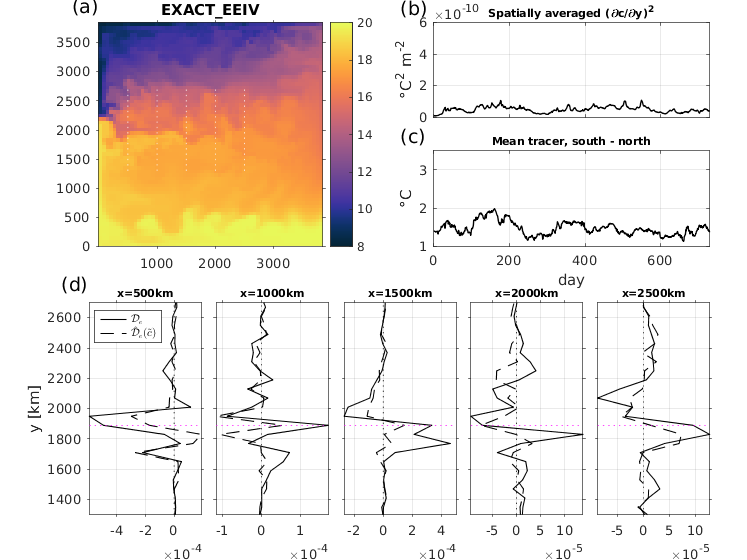

In [9]:
[x, y] = deal(grid.lonh, grid.lath);

x_section_al = 500:500:2500; % km 
% ylims_crs = [1600 2400];
ylims_crs = [1300 2700];

nsecs = numel(x_section_al);
for icel = 1:nsecs
    x_section = x_section_al(icel);
    [~, ii_sec_al(icel)] = min(abs(x - x_section));
end

it = 361; t_al(it)
it_do = 1:nt_al;
fld2d_1 = squeeze(mean(eforc_al(:,:,it_do), [3]));
fld2d_2 = squeeze(mean(eforc2_al(:,:,it_do),[ 3]));
styles = {'k-','k--'}; 
titles = {'$\mathcal{D}_e$', '$\hat{\mathcal{D}}_e(\tilde{c})$'};
ftsz_title = 8;

x_top = 0.12; y_top = 0.56; h_top = 0.4; w_top = h_top; dx_top = 0.03; dy_top = 0.03;
x_crs = 0.12; y_crs = 0.08; h_crs = 0.38; w_crs = 0.15; dx_crs = 0.02;
pos_top = { [x_top y_top w_top h_top], [x_top+w_top+dx_top*2 y_top+h_top/2+dy_top w_top-0.03 h_top/2-0.03], ...
                                       [x_top+w_top+dx_top*2 y_top w_top-0.03 h_top/2-0.03]};
pos_crs = { [x_crs                y_crs w_crs h_crs], ...
            [x_crs+w_crs+dx_crs   y_crs w_crs h_crs], ...
            [x_crs+2*(w_crs+dx_crs) y_crs w_crs h_crs], ...
            [x_crs+3*(w_crs+dx_crs) y_crs w_crs h_crs], ...
            [x_crs+4*(w_crs+dx_crs) y_crs w_crs h_crs]};

% -----------
font = 'DejaVu Sans';
figure('DefaultTextFontName', font, 'DefaultAxesFontName', font);

% ------------------------
subplot('Position',pos_top{1});
clim = [8 20];
f_do = c2_al(:,:,it); 
imagescn(x, y, f_do'); set(gca,'tickdir','out','xtick',[1e3:1e3:3e3]);
cmocean('thermal'); axis square; caxis(clim)
for icel_crs = 1:nsecs
    vhd = vline(x_section_al(icel_crs),':w');
    vhd.YData = ylims_crs;
end
% hold on; scatter(x_GSC_m, y_GSC_m,8,'.m')
cb = colorbar;
% cb.XTick = clim(1):2:clim(2);
% title('c, with exact \chi_{\perp}')
title('EXACT\_EEIV')

ax = gca;
hb(1) = subplotlabel(ax,'a','location','northwestoutside',...
    'offset',[-0.12 0.02],'Prefix','(','Postfix',')','fontsize',14);
    
% ------------------------
subplot('Position',pos_top{2});
plot(t_al,mean_GSC,'k','linewidth',1);
hold on
set(gca,'XLim',[0 t_al(end)],'ylim',[0 6]*1e-10)
set(gca,'xticklabel','')
grid on
ylabel('\circC^2 m^{-2}')
title('Spatially averaged (\partial{c}/\partial{y})^2','fontsize',ftsz_title)
ax(2) = gca;
hb(2) = subplotlabel(ax(2),'b','location','northwestoutside',...
    'offset',[-0.12 0.02],'Prefix','(','Postfix',')','fontsize',14);

% ------------------------
subplot('Position',pos_top{3});
plot(t_al,fld_sum_S{1} - fld_sum_N{1}, 'k','linewidth', 1)
grid on
set(gca,'XLim',[0 t_al(end)],'ylim',[1 3.5]);
xlabel('day')
ylabel('\circC')
title('Mean tracer, south - north','fontsize',ftsz_title)
ax(3) = gca;
hb(3) = subplotlabel(ax(3),'c','location','northwestoutside',...
    'offset',[-0.12 0.02],'Prefix','(','Postfix',')','fontsize',14);

% ------------------------ bottom
for icel = 1:nsecs

    [ii_sec, x_section] = deal(ii_sec_al(icel), x_section_al(icel));
    subplot('Position',pos_crs{icel});
    
    plot(fld2d_1(ii_sec,:), y, styles{1}, 'linewidth', .8);
    hold on
    plot(fld2d_2(ii_sec,:), y, styles{2}, 'linewidth', .8); 
    
    ax(icel+3) = gca;
    ax(icel+3).XGrid = 'on'; ax(icel+3).YGrid = 'on';
    % ax.XLim = [-5 5]*1e-4;
    ax(icel+3).YLim = ylims_crs;
    ax(icel+3).TickDir = 'out';
    if icel~=1; ax(icel+3).YTickLabel = ''; end
    if icel == 1 
        ylabel('y [km]'); 
        ldg = legend(titles,'location','northwest','NumColumns',1,'fontsize',8,'interpreter','latex');
        ldg.ItemTokenSize = [20 10];
    end    
    hold on; hline(mean(y_GSC_m),':m','HandleVisibility','off');
    hold on; vline(0,':k','HandleVisibility','off');
    title(['x=' num2str(x_section) 'km'],'fontsize',ftsz_title)
    
    if icel == 1
        hb(4) = subplotlabel(ax(4),'d','location','northwestoutside',...
            'offset',[-0.25 0.03],'Prefix','(','Postfix',')','fontsize',14);
    end
end

% ---
set(gcf,'PaperPositionMode','auto'); 
fignm = [homedir '/work_MOM/figures/fig_error_exactchi_new'];
% exportgraphics(gcf,[fignm '.pdf'], 'BackgroundColor','white','ContentType','vector')